<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/RegressionMapClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import shap


In [5]:
bi3 = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
bi3 = bi3.iloc[:, 1:]

In [6]:
bi3['NATNL'] = bi3['NATNL'].replace({0: 'Asian', 1: 'Asian', 3: 'Asian', 2: 'Non-Asian'})

In [7]:
bi3 = bi3.sort_values(['PatientUID', 'PatientVisitUID'])
bi3['TimeDiff'] = bi3.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
bi3['TimeDiff'] = bi3['TimeDiff'].fillna(0)

In [8]:
bi3['time_t1'] = pd.to_datetime(bi3['time_t1'])

In [9]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(bi3[column].unique())}
    bi3[column] = bi3[column].map(encoding_map)

In [10]:
def categorize_eGFR(eGFR_value):
    if eGFR_value >= 90:
        return 0
    elif eGFR_value >= 60:
        return 1
    elif eGFR_value >= 30:
        return 2
    elif eGFR_value >= 15:
        return 3
    else:
        return 4

bi3['Stage'] = bi3['eGFR_t1'].apply(categorize_eGFR)

# GridSearch

In [11]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/xgb_slopes_binary3.json'
with open(json_file_path, 'r') as f:
    xgb_slopes_binary3 = json.load(f)

print(xgb_slopes_binary3)

[{'fold': 1, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': -77.16153599891285}, {'fold': 2, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, 'best_score': -76.6291122430406}, {'fold': 3, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': -76.1579280876254}, {'fold': 4, 'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}, 'best_score': -77.82291052884017}, {'fold': 5, 'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}, 'best_score': -76.5136984438426}]


In [12]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/rf_slopes_binary3.json'
with open(json_file_path, 'r') as f:
    rf_slopes_binary3 = json.load(f)

print(rf_slopes_binary3)

[{'fold': 1, 'best_params': {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}, 'best_score': -78.67065605863677}, {'fold': 2, 'best_params': {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}, 'best_score': -78.8741897406417}, {'fold': 3, 'best_params': {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}, 'best_score': -80.4619986199188}, {'fold': 4, 'best_params': {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}, 'best_score': -79.54317817243754}, {'fold': 5, 'best_params': {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}, 'best_score': -78.75919818151161}]


In [13]:
import json

json_file_path = '/content/drive/MyDrive/ckdresearch2023/Assign/GridSearch/svr_slopes_binary3.json'
with open(json_file_path, 'r') as f:
    svr_slopes_binary3 = json.load(f)

print(svr_slopes_binary3)

[{'fold': 1, 'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, 'best_score': -79.96580712391642}, {'fold': 2, 'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, 'best_score': -80.1719222341857}, {'fold': 3, 'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, 'best_score': -81.21024747332282}, {'fold': 4, 'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, 'best_score': -82.18391024977988}, {'fold': 5, 'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, 'best_score': -80.52440932151521}]


# Split

In [14]:
X = bi3.drop(['Group','Stage','Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold','VisitLocation'], axis=1)
y = bi3['Slopes']

In [15]:

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
X = bi3.drop(['Group','Stage','Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold','VisitLocation'], axis=1)
y = bi3['Slopes']
all_folds = bi3['Fold'].unique()
X_train_scaled_list_bi3 = []
y_train_list_bi3 = []
X_test_scaled_list_bi3 = []
y_test_list_bi3 = []
for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]
    train_indices = bi3['Fold'].isin(train_folds)
    test_indices = bi3['Fold'] == val_fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    X_train_scaled_list_bi3.append(X_train_scaled)
    y_train_list_bi3.append(y_train)
    X_test_scaled_list_bi3.append(X_test_scaled)
    y_test_list_bi3.append(y_test)
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices
    print(f"Training set size: {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")


Training set size: (41978, 119)
Test set size: (10642, 119)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---

Training set size: (42274, 119)
Test set size: (10346, 119)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---

Training set size: (42027, 119)
Test set size: (10593, 119)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Training set size: (42017, 119)
Test set size: (10603, 119)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---

Training set size: (42184, 119)
Test set size: (10436, 119)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---



## Class

In [16]:
value_mapping = {0: 'rapid', 1: 'better', 2: 'prevention'}
bi3['Group'] = bi3['Group'].replace(value_mapping)

In [17]:
bi3['Group'].value_counts()

better        22980
rapid         16337
prevention    13303
Name: Group, dtype: int64

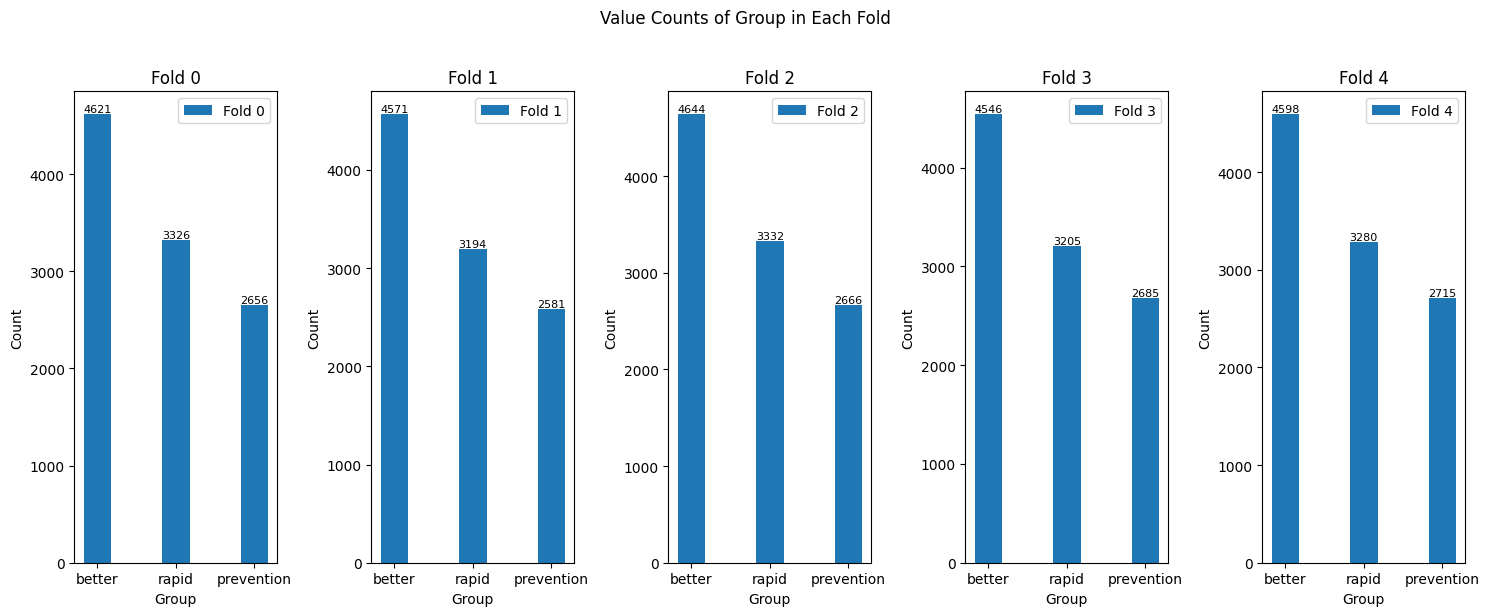

In [18]:
import matplotlib.pyplot as plt
import numpy as np

num_folds = 5
fig, axes = plt.subplots(nrows=1, ncols=num_folds, figsize=(15, 6))  # Use subplots to create separate axes for each fold

bar_width = 0.35
for fold_index, ax in enumerate(axes):
    fold_df = bi3[bi3['Fold'] == fold_index]
    group_value_counts = fold_df['Group'].value_counts()

    bar_positions = np.arange(len(group_value_counts))  # Adjust the positions of the bars based on the number of unique groups

    bars = ax.bar(bar_positions, group_value_counts.values, width=bar_width, label=f'Fold {fold_index}')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(group_value_counts.index)
    ax.set_xlabel('Group')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'Fold {fold_index}')
    for bar, count in zip(bars, group_value_counts.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                ha='center', va='bottom', fontsize=8, color='black')
plt.suptitle('Value Counts of Group in Each Fold', y=1.02)
plt.tight_layout()
plt.show()

In [19]:
def categorize_slope(slope):
    if slope < -5:
        return 'rapid'
    elif -5 <= slope <= -0.75:
        return 'prevention'
    else:
        return 'better'

# XGB

In [25]:
xgb_slopes_binary3

[{'fold': 1,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
  'best_score': -77.16153599891285},
 {'fold': 2,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  'best_score': -76.6291122430406},
 {'fold': 3,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
  'best_score': -76.1579280876254},
 {'fold': 4,
  'best_params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150},
  'best_score': -77.82291052884017},
 {'fold': 5,
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150},
  'best_score': -76.5136984438426}]

In [26]:
xgb_best_params = xgb_slopes_binary3[2]['best_params']
xgb_best_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [27]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [28]:
X = bi3.drop(['Group','Stage','Slopes', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'LabLocation', 'Fold','VisitLocation'], axis=1)
y = bi3['Slopes']

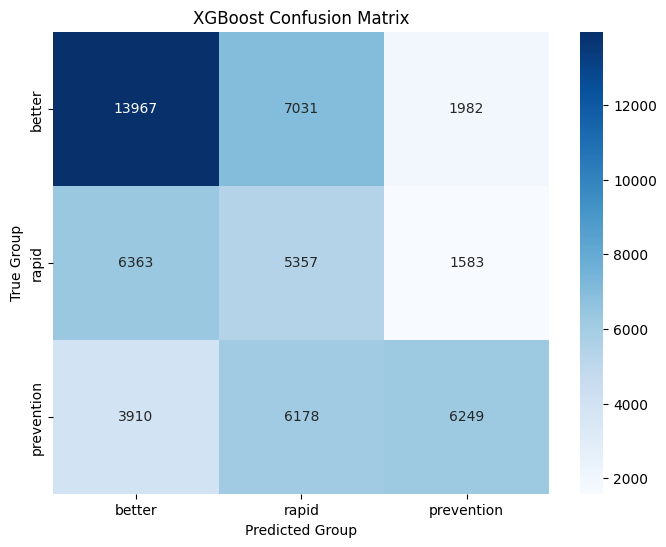

In [29]:
# Create a DataFrame to store the evaluation metrics
performance_xgb = pd.DataFrame(columns=['MSE', 'MAE', 'R-squared'])
comparison_xgb = pd.DataFrame(columns=['Fold', 'SlopesTrue', 'SlopesPredicted'])

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Train the model only with the best parameters from fold 3
    xgbmodel = XGBRegressor(**xgb_best_params)
    xgbmodel.fit(X_train_scaled_fold, y_train_fold)

    # Make predictions on the test data for the current fold
    xgb_y_pred = xgbmodel.predict(X_test_scaled_fold)

    # Append the predicted and true values to the DataFrame
    comparison_xgb = pd.concat([comparison_xgb, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                          'SlopesTrue': y_test_fold,
                                                          'SlopesPredicted': xgb_y_pred})],
                                           ignore_index=True)

    # Evaluate the model performance for the current fold
    mse = mean_squared_error(y_test_fold, xgb_y_pred)
    mae = mean_absolute_error(y_test_fold, xgb_y_pred)
    r2 = r2_score(y_test_fold, xgb_y_pred)

    # Append scores to the DataFrame
    performance_xgb.loc[f'Fold {fold + 1}'] = [mse, mae, r2]

# Calculate mean scores across all folds
bi3_mean_mse = performance_xgb['MSE'].mean()
bi3_mean_mae = performance_xgb['MAE'].mean()
bi3_mean_r2 = performance_xgb['R-squared'].mean()

# Add a row for overall mean scores
performance_xgb.loc['Overall'] = [bi3_mean_mse, bi3_mean_mae, bi3_mean_r2]

# Create a new column in comparison_xgb for true groups
comparison_xgb['GroupTrue'] = comparison_xgb['SlopesTrue'].apply(categorize_slope)

# Create a new column for predicted groups
comparison_xgb['GroupPredicted'] = comparison_xgb['SlopesPredicted'].apply(categorize_slope)

# Calculate confusion matrix
conf_matrix_xgb = confusion_matrix(comparison_xgb['GroupTrue'], comparison_xgb['GroupPredicted'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'])
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('XGBoost Confusion Matrix')
plt.show()


In [30]:
print("Performance Metrics:")
performance_xgb

Performance Metrics:


,MSE,MAE,R-squared
Fold 1,78.085798,6.058738,0.216871
Fold 2,77.572193,6.021702,0.220734
Fold 3,71.086564,5.868220,0.197049
Fold 4,73.988215,5.941533,0.210119
Fold 5,76.305647,5.942047,0.216606
Overall,75.407683,5.966448,0.212276


In [31]:
print("\nComparison Table:")
comparison_xgb.head(10)


Comparison Table:


,Fold,SlopesTrue,SlopesPredicted,GroupTrue,GroupPredicted
0,1,-8.126415,-2.752852,rapid,prevention
1,1,0.877756,0.647398,better,better
2,1,0.169439,0.697743,better,better
3,1,-3.392731,0.710051,prevention,better
4,1,-9.794421,-4.396647,rapid,prevention
5,1,6.203656,1.818810,better,better
6,1,-5.722011,0.194080,rapid,better
7,1,1.860620,1.264889,better,better
8,1,-5.087108,-0.211539,rapid,better
9,1,5.338223,0.139798,better,better


# RF

In [32]:
rf_slopes_binary3

[{'fold': 1,
  'best_params': {'bootstrap': True,
   'max_depth': 20,
   'min_samples_split': 5,
   'n_estimators': 100},
  'best_score': -78.67065605863677},
 {'fold': 2,
  'best_params': {'bootstrap': True,
   'max_depth': 20,
   'min_samples_split': 2,
   'n_estimators': 150},
  'best_score': -78.8741897406417},
 {'fold': 3,
  'best_params': {'bootstrap': True,
   'max_depth': 20,
   'min_samples_split': 2,
   'n_estimators': 150},
  'best_score': -80.4619986199188},
 {'fold': 4,
  'best_params': {'bootstrap': True,
   'max_depth': 20,
   'min_samples_split': 2,
   'n_estimators': 150},
  'best_score': -79.54317817243754},
 {'fold': 5,
  'best_params': {'bootstrap': True,
   'max_depth': 20,
   'min_samples_split': 2,
   'n_estimators': 150},
  'best_score': -78.75919818151161}]

In [33]:
rf_best_params = rf_slopes_binary3[0]['best_params']
rf_best_params

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_split': 5,
 'n_estimators': 100}

In [34]:
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


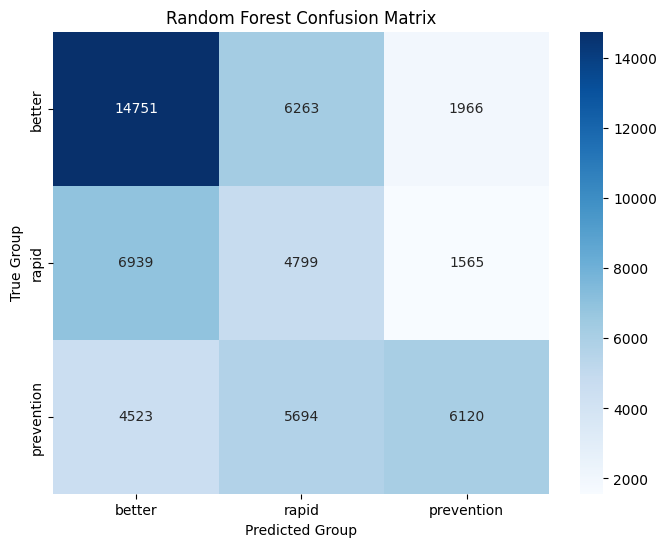

In [35]:
performance_rf = pd.DataFrame(columns=['MSE', 'MAE', 'R-squared'])
comparison_rf = pd.DataFrame(columns=['Fold', 'SlopesTrue', 'SlopesPredicted'])

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Train the model only with the best parameters
    rf_model = RandomForestRegressor(**rf_best_params)
    rf_model.fit(X_train_scaled_fold, y_train_fold)

    # Make predictions on the test data for the current fold
    rf_y_pred = rf_model.predict(X_test_scaled_fold)

    # Append the predicted and true values to the DataFrame
    comparison_rf = pd.concat([comparison_rf, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                          'SlopesTrue': y_test_fold,
                                                          'SlopesPredicted': rf_y_pred})],
                                           ignore_index=True)

    # Evaluate the model performance for the current fold
    mse = mean_squared_error(y_test_fold, rf_y_pred)
    mae = mean_absolute_error(y_test_fold, rf_y_pred)
    r2 = r2_score(y_test_fold, rf_y_pred)

    # Append scores to the DataFrame
    performance_rf.loc[f'Fold {fold + 1}'] = [mse, mae, r2]

# Calculate mean scores across all folds
bi3_mean_mse_rf = performance_rf['MSE'].mean()
bi3_mean_mae_rf = performance_rf['MAE'].mean()
bi3_mean_r2_rf = performance_rf['R-squared'].mean()

# Add a row for overall mean scores
performance_rf.loc['Overall'] = [bi3_mean_mse_rf, bi3_mean_mae_rf, bi3_mean_r2_rf]

# Create a new column in comparison_rf for true groups
comparison_rf['GroupTrue'] = comparison_rf['SlopesTrue'].apply(categorize_slope)

# Create a new column for predicted groups
comparison_rf['GroupPredicted'] = comparison_rf['SlopesPredicted'].apply(categorize_slope)

# Calculate confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(comparison_rf['GroupTrue'], comparison_rf['GroupPredicted'])

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'])
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [36]:
print("\nPerformance Metrics for Random Forest:")
performance_rf


Performance Metrics for Random Forest:


,MSE,MAE,R-squared
Fold 1,81.111489,6.150110,0.186526
Fold 2,79.715095,6.077597,0.199207
Fold 3,73.878895,5.949062,0.165508
Fold 4,76.902517,6.024842,0.179007
Fold 5,79.725020,6.036315,0.181501
Overall,78.266603,6.047585,0.182350


In [37]:
print("\nComparison:")
comparison_rf


Comparison:


,Fold,SlopesTrue,SlopesPredicted,GroupTrue,GroupPredicted
0,1,-8.126415,-3.392880,rapid,prevention
1,1,0.877756,0.376943,better,better
2,1,0.169439,0.277541,better,better
3,1,-3.392731,0.272907,prevention,better
4,1,-9.794421,-3.931658,rapid,prevention
...,...,...,...,...,...
52615,5,7.391940,-0.022946,better,better
52616,5,8.212500,1.454108,better,better
52617,5,8.638005,2.328675,better,better
52618,5,10.568365,13.838314,better,better


#FNN

327/327 [==============================] - 1s 2ms/step


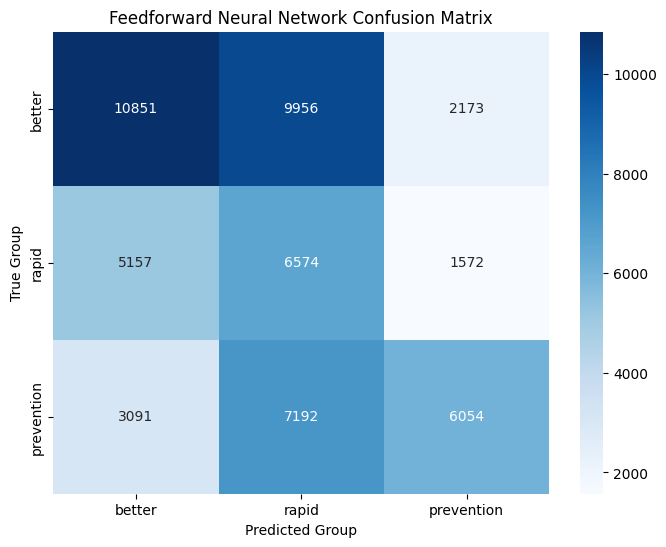

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create a DataFrame to store the evaluation metrics
performance_fnn = pd.DataFrame(columns=['MSE', 'MAE', 'R-squared'])
comparison_fnn = pd.DataFrame(columns=['Fold', 'SlopesTrue', 'SlopesPredicted'])

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Define the FNN model architecture
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled_fold.shape[1], activation='linear', kernel_regularizer='l1'))
    model.add(Dense(128, activation='linear', kernel_regularizer='l1'))
    model.add(Dense(64, activation='linear', kernel_regularizer='l1'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)  # Reduced learning rate
    model.compile(loss="mean_squared_error", optimizer=optimizer)

    # Train the model
    history = model.fit(X_train_scaled_fold, y_train_fold, epochs=50, batch_size=32, verbose=0, validation_data=(X_test_scaled_fold, y_test_fold))

    # Make predictions on the test data for the current fold
    fnn_y_pred = model.predict(X_test_scaled_fold)

    # Append the predicted and true values to the DataFrame
    comparison_fnn = pd.concat([comparison_fnn, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                          'SlopesTrue': y_test_fold,
                                                          'SlopesPredicted': fnn_y_pred.flatten()})],
                                           ignore_index=True)

    # Evaluate the model performance for the current fold
    mse = mean_squared_error(y_test_fold, fnn_y_pred)
    mae = mean_absolute_error(y_test_fold, fnn_y_pred)
    r2 = r2_score(y_test_fold, fnn_y_pred)

    # Append scores to the DataFrame
    performance_fnn.loc[f'Fold {fold + 1}'] = [mse, mae, r2]

# Calculate mean scores across all folds
bi3_mean_mse_fnn = performance_fnn['MSE'].mean()
bi3_mean_mae_fnn = performance_fnn['MAE'].mean()
bi3_mean_r2_fnn = performance_fnn['R-squared'].mean()

# Add a row for overall mean scores
performance_fnn.loc['Overall'] = [bi3_mean_mse_fnn, bi3_mean_mae_fnn, bi3_mean_r2_fnn]

# Create a new column in comparison_fnn for true groups
comparison_fnn['GroupTrue'] = comparison_fnn['SlopesTrue'].apply(categorize_slope)

# Create a new column for predicted groups
comparison_fnn['GroupPredicted'] = comparison_fnn['SlopesPredicted'].apply(categorize_slope)

# Calculate confusion matrix for FNN
conf_matrix_fnn = confusion_matrix(comparison_fnn['GroupTrue'], comparison_fnn['GroupPredicted'])

# Plot confusion matrix for FNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'])
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('Feedforward Neural Network Confusion Matrix')
plt.show()


In [39]:
# Print the performance metrics DataFrame for FNN
print("Performance Metrics for Feedforward Neural Network:")
print(performance_fnn)

Performance Metrics for Feedforward Neural Network:
                MSE       MAE  R-squared
Fold 1    84.476670  6.284741   0.152776
Fold 2    84.801408  6.250607   0.148111
Fold 3    82.581807  6.154727   0.067205
Fold 4   158.417335  6.254085  -0.691226
Fold 5    83.071876  6.214353   0.147140
Overall   98.669819  6.231703  -0.035199


In [40]:
comparison_fnn.head()

,Fold,SlopesTrue,SlopesPredicted,GroupTrue,GroupPredicted
0,1,-8.126415,-1.975787,rapid,prevention
1,1,0.877756,-0.599131,better,better
2,1,0.169439,-0.076661,better,better
3,1,-3.392731,-1.089762,prevention,prevention
4,1,-9.794421,-3.723497,rapid,prevention


In [41]:
print("\nComparison:")
comparison_fnn


Comparison:


,Fold,SlopesTrue,SlopesPredicted,GroupTrue,GroupPredicted
0,1,-8.126415,-1.975787,rapid,prevention
1,1,0.877756,-0.599131,better,better
2,1,0.169439,-0.076661,better,better
3,1,-3.392731,-1.089762,prevention,prevention
4,1,-9.794421,-3.723497,rapid,prevention
...,...,...,...,...,...
52615,5,7.391940,-1.443154,better,prevention
52616,5,8.212500,3.537929,better,better
52617,5,8.638005,-2.271890,better,prevention
52618,5,10.568365,5.498158,better,better


# SVR

In [42]:
svr_slopes_binary3

[{'fold': 1,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'},
  'best_score': -79.96580712391642},
 {'fold': 2,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'},
  'best_score': -80.1719222341857},
 {'fold': 3,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'},
  'best_score': -81.21024747332282},
 {'fold': 4,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'},
  'best_score': -82.18391024977988},
 {'fold': 5,
  'best_params': {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'},
  'best_score': -80.52440932151521}]

In [43]:
svr_best_params = svr_slopes_binary3[0]['best_params']
svr_best_params

{'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

In [44]:
from sklearn import svm
from sklearn.svm import SVR

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


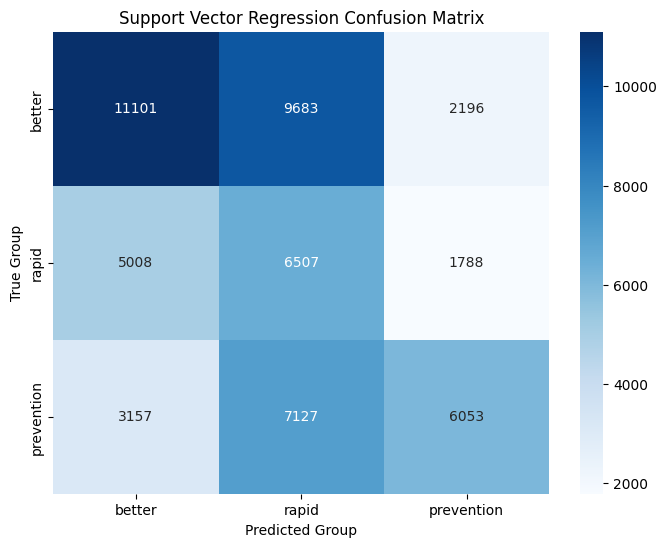

In [45]:
performance_svr = pd.DataFrame(columns=['MSE', 'MAE', 'R-squared'])
comparison_svr = pd.DataFrame(columns=['Fold', 'SlopesTrue', 'SlopesPredicted'])

# Loop through each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold) in enumerate(
        zip(X_train_scaled_list_bi3, y_train_list_bi3, X_test_scaled_list_bi3, y_test_list_bi3)):

    # Train the model only with the best parameters
    svr_model = SVR(**svr_best_params)
    svr_model.fit(X_train_scaled_fold, y_train_fold)

    # Make predictions on the test data for the current fold
    svr_y_pred = svr_model.predict(X_test_scaled_fold)

    # Append the predicted and true values to the DataFrame
    comparison_svr = pd.concat([comparison_svr, pd.DataFrame({'Fold': [fold + 1]*len(y_test_fold),
                                                          'SlopesTrue': y_test_fold,
                                                          'SlopesPredicted': svr_y_pred})],
                                           ignore_index=True)

    # Evaluate the model performance for the current fold
    mse = mean_squared_error(y_test_fold, svr_y_pred)
    mae = mean_absolute_error(y_test_fold, svr_y_pred)
    r2 = r2_score(y_test_fold, svr_y_pred)

    # Append scores to the DataFrame
    performance_svr.loc[f'Fold {fold + 1}'] = [mse, mae, r2]

# Calculate mean scores across all folds
bi3_mean_mse_svr = performance_svr['MSE'].mean()
bi3_mean_mae_svr = performance_svr['MAE'].mean()
bi3_mean_r2_svr = performance_svr['R-squared'].mean()

# Add a row for overall mean scores
performance_svr.loc['Overall'] = [bi3_mean_mse_svr, bi3_mean_mae_svr, bi3_mean_r2_svr]

# Create a new column in comparison_svr for true groups
comparison_svr['GroupTrue'] = comparison_svr['SlopesTrue'].apply(categorize_slope)

# Create a new column for predicted groups
comparison_svr['GroupPredicted'] = comparison_svr['SlopesPredicted'].apply(categorize_slope)

# Calculate confusion matrix for SVR
conf_matrix_svr = confusion_matrix(comparison_svr['GroupTrue'], comparison_svr['GroupPredicted'])

# Plot confusion matrix for SVR
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svr, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'])
plt.xlabel('Predicted Group')
plt.ylabel('True Group')
plt.title('Support Vector Regression Confusion Matrix')
plt.show()


In [46]:
print("\nPerformance Metrics for Support Vector Regression:")
performance_svr


Performance Metrics for Support Vector Regression:


,MSE,MAE,R-squared
Fold 1,83.406736,6.234223,0.163507
Fold 2,83.199550,6.174055,0.164203
Fold 3,73.985060,5.967733,0.164309
Fold 4,78.146140,6.096677,0.165730
Fold 5,80.600097,6.103820,0.172517
Overall,79.867517,6.115301,0.166053


In [47]:
print("\nComparison:")
comparison_svr


Comparison:


,Fold,SlopesTrue,SlopesPredicted,GroupTrue,GroupPredicted
0,1,-8.126415,-1.779684,rapid,prevention
1,1,0.877756,-0.740239,better,better
2,1,0.169439,0.423698,better,better
3,1,-3.392731,0.459762,prevention,better
4,1,-9.794421,-3.467091,rapid,prevention
...,...,...,...,...,...
52615,5,7.391940,0.463137,better,better
52616,5,8.212500,2.467837,better,better
52617,5,8.638005,-0.956591,better,prevention
52618,5,10.568365,1.504727,better,better


# Summary

In [49]:
results = {
    'XGBoost': performance_xgb.iloc[-1:],
    'RandomForest': performance_rf.iloc[-1:],
    'Feedforward Neural Network': performance_fnn.iloc[-1:],
    'Support Vector Machine': performance_svr.iloc[-1:]
}

# Concatenate the DataFrames
regression_performance = pd.concat(results.values(), keys=results.keys())
regression_performance.reset_index(level=1, drop=True, inplace=True)

regression_performance.index.name = 'Model'
regression_performance

,MSE,MAE,R-squared
Model,,,
XGBoost,75.407683,5.966448,0.212276
RandomForest,78.266603,6.047585,0.182350
Feedforward Neural Network,98.669819,6.231703,-0.035199
Support Vector Machine,79.867517,6.115301,0.166053


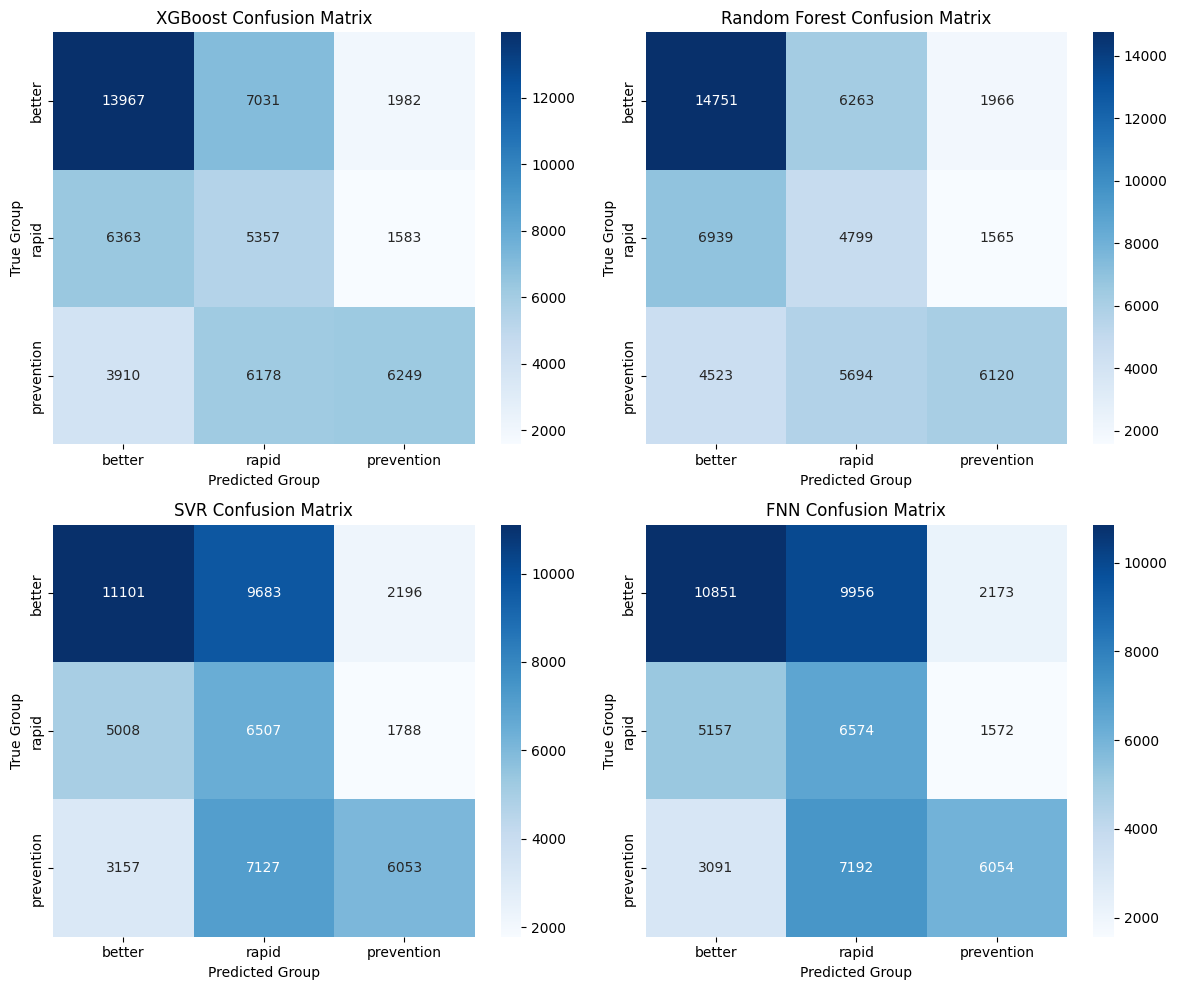

In [48]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# XGBoost Confusion Matrix
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'], ax=axes[0, 0])
axes[0, 0].set_title('XGBoost Confusion Matrix')
axes[0, 0].set_xlabel('Predicted Group')
axes[0, 0].set_ylabel('True Group')

# Random Forest Confusion Matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'], ax=axes[0, 1])
axes[0, 1].set_title('Random Forest Confusion Matrix')
axes[0, 1].set_xlabel('Predicted Group')
axes[0, 1].set_ylabel('True Group')

# SVR Confusion Matrix
sns.heatmap(conf_matrix_svr, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'], ax=axes[1, 0])
axes[1, 0].set_title('SVR Confusion Matrix')
axes[1, 0].set_xlabel('Predicted Group')
axes[1, 0].set_ylabel('True Group')

# SVR Confusion Matrix for FNN model
sns.heatmap(conf_matrix_fnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=['better', 'rapid', 'prevention'],
            yticklabels=['better', 'rapid', 'prevention'], ax=axes[1, 1])
axes[1, 1].set_title('FNN Confusion Matrix')
axes[1, 1].set_xlabel('Predicted Group')
axes[1, 1].set_ylabel('True Group')

plt.tight_layout()
plt.show()
